# **Bitcoin Price Prediction - LSTM**

##### **Copyrigt© E.M.L.Silva, M.M.Abidh, V.Gimhan, K.M.Senevirathne**

## **Import Dependancies**

In [130]:
import pandas as pd
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
import io
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [131]:
import warnings
warnings.filterwarnings("ignore")

#  **1. Exploratory Data Analysis (EDA)**

#### **1.1 Import Dataset**

In [132]:
df = pd.read_csv('../data/BTC-USD.csv')

#### **1.2 Check Dataset Properties**

In [133]:
print("Top rows:")
df.head()

Top rows:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-21,234.016006,236.242004,233.835007,235.343994,235.343994,15108900
1,2015-05-22,235.320999,240.968994,235.059998,240.348007,240.348007,27003000
2,2015-05-23,240.285995,241.024994,238.690994,238.871994,238.871994,14605000
3,2015-05-24,238.975998,241.977997,238.811005,240.953003,240.953003,11508000
4,2015-05-25,240.927002,241.020996,236.636993,237.110001,237.110001,14423900


In [134]:
print("Bottom rows:")
df.tail()

Bottom rows:


,Date,Open,High,Low,Close,Adj Close,Volume
3284,2024-05-17,65231.296875,67459.460938,65119.316406,67051.875000,67051.875000,28031279310
3285,2024-05-18,67066.210938,67387.328125,66663.500000,66940.804688,66940.804688,16712277406
3286,2024-05-19,66937.929688,67694.296875,65937.179688,66278.367188,66278.367188,19249094538
3287,2024-05-20,66278.742188,71483.562500,66086.171875,71448.195313,71448.195313,43850655717
3288,2024-05-21,71427.992188,71785.109375,70773.343750,71124.765625,71124.765625,55098576896


In [135]:
df.shape

(3289, 7)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3289 non-null   object 
 1   Open       3289 non-null   float64
 2   High       3289 non-null   float64
 3   Low        3289 non-null   float64
 4   Close      3289 non-null   float64
 5   Adj Close  3289 non-null   float64
 6   Volume     3289 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 180.0+ KB


In [137]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3289.000000,3289.000000,3289.000000,3289.000000,3289.000000,3.289000e+03
mean,17492.488542,17900.652107,17058.290363,17512.708965,17512.708965,1.850676e+10
std,18192.482131,18626.696839,17718.041898,18211.605427,18211.605427,1.935494e+10
min,210.067993,225.718994,199.567001,210.494995,210.494995,1.060090e+07
25%,3421.910400,3495.174805,3372.120117,3448.116943,3448.116943,1.663280e+09
50%,9413.004883,9575.544922,9249.500000,9412.612305,9412.612305,1.514493e+10
75%,28450.457031,29076.400391,28037.257813,28454.978516,28454.978516,2.908356e+10
max,73079.375000,73750.070313,71334.093750,73083.500000,73083.500000,3.509679e+11


#### **1.3 Check Date Range**

In [138]:
df['Date']  = pd.to_datetime(df['Date'])

min_date = df['Date'].min()
max_date = df['Date'].max()

# Print date range
print(f"Date range: {min_date} to {max_date}")

Date range: 2015-05-21 00:00:00 to 2024-05-21 00:00:00


#### **1.4 Price Distributions over Time**

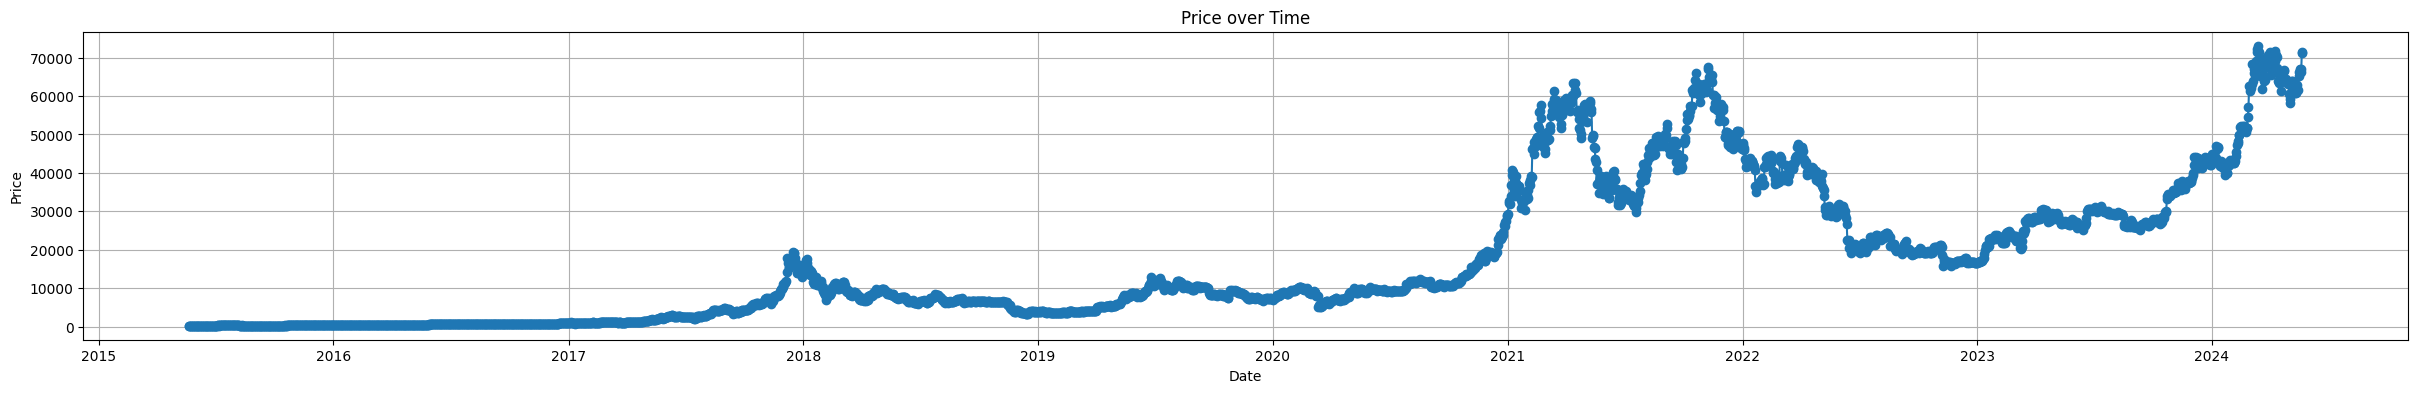

In [139]:
# Plotting
plt.figure(figsize=(30, 4))
plt.plot(df['Date'], df['Close'], marker='o')
plt.title('Price over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Here we can observe that the timeseries components have been subjected to change a lot, since a larger dataset is considered. So, if we use data that is no longer relevant, as a result of that, it will affect the accuracy of the predictions. Therefore the dataset is sliced for 2 years of time to prevent observing such cases.

#### **1.5 Slice Dataset**

In [140]:
# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [141]:
start_date = '2022-05-21'
df = df[df['Date'] >= start_date]

In [142]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2557,2022-05-21,29199.859375,29588.869141,29027.394531,29432.226563,29432.226563,17274840442
2558,2022-05-22,29432.472656,30425.861328,29275.183594,30323.722656,30323.722656,21631532270
2559,2022-05-23,30309.396484,30590.585938,28975.560547,29098.910156,29098.910156,31483454557
2560,2022-05-24,29101.125000,29774.355469,28786.589844,29655.585938,29655.585938,26616506245
2561,2022-05-25,29653.134766,30157.785156,29384.949219,29562.361328,29562.361328,27525063551


In [143]:
df.shape

(732, 7)

#### **1.6 Check for Null Values**

In [144]:
# Check for null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### **1.7 Price over Time**

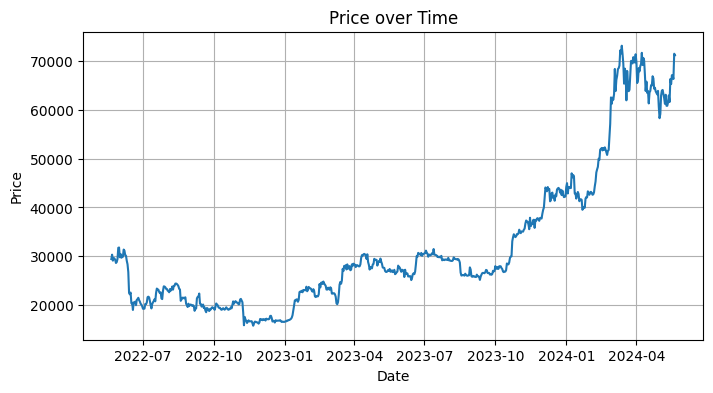

In [145]:
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(df['Date'], df['Close'])
plt.title('Price over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### **1.8 Price Movements over Time**

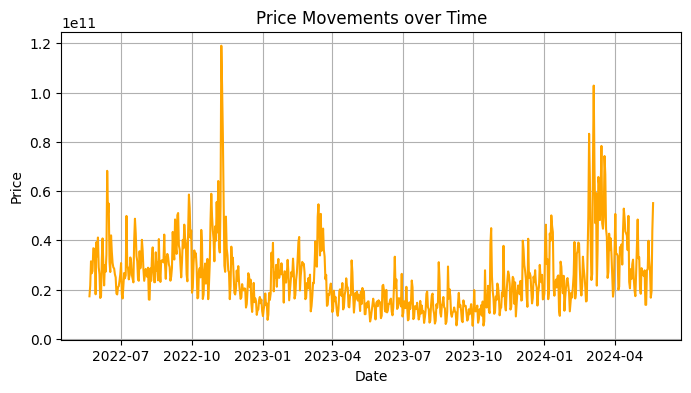

In [146]:
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(df['Date'], df['Volume'], color='orange')
plt.title('Price Movements over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

#### **1.9 Volume Traded by Year**

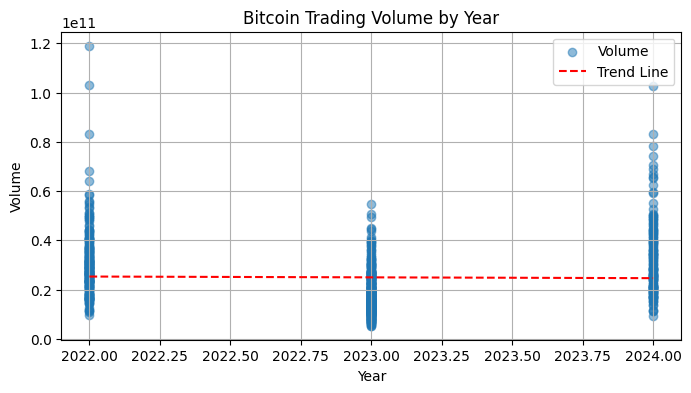

In [147]:
# Bitcoin Trading Volume by Year
y_filtered = df[['Date', 'Volume']]
y_filtered['Year'] = y_filtered['Date'].dt.year

plt.figure(figsize=(8, 4))
plt.scatter(y_filtered['Year'], y_filtered['Volume'], alpha=0.5, label='Volume')
z = np.polyfit(y_filtered['Year'], y_filtered['Volume'], 1)
p = np.poly1d(z)
plt.plot(y_filtered['Year'], p(y_filtered['Year']), "r--", label='Trend Line')
plt.title('Bitcoin Trading Volume by Year')
plt.xlabel('Year')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()
plt.show()

#### **1.10 Month wise Open/Close Price**

<Figure size 800x400 with 0 Axes>

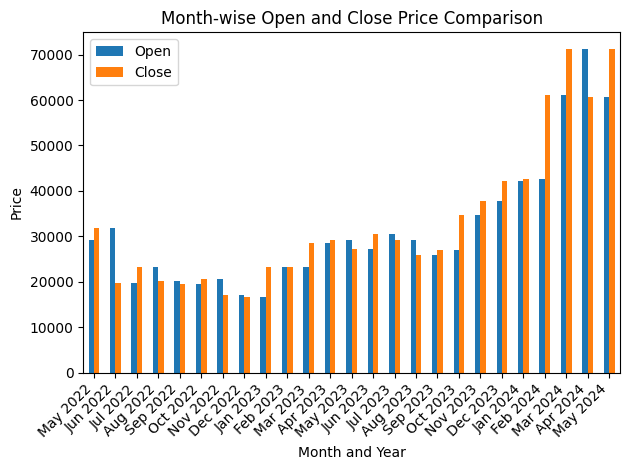

In [148]:
# Group by month and get the first 'Open' price and the last 'Close' price for each month
monthly_data = df.groupby(pd.Grouper(key='Date', freq='M')).agg({'Open': 'first', 'Close': 'last'}).reset_index()

# Extract month and year
monthly_data['Month_Year'] = monthly_data['Date'].dt.strftime('%b %Y')

# Plot the comparison chart
plt.figure(figsize=(8, 4))
monthly_data.plot(x='Month_Year', y=['Open', 'Close'], kind='bar')
plt.title('Month-wise Open and Close Price Comparison')
plt.xlabel('Month and Year')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.legend(['Open', 'Close'])
plt.tight_layout()
plt.show()

#### **1.11 Month wise Trading Volume**

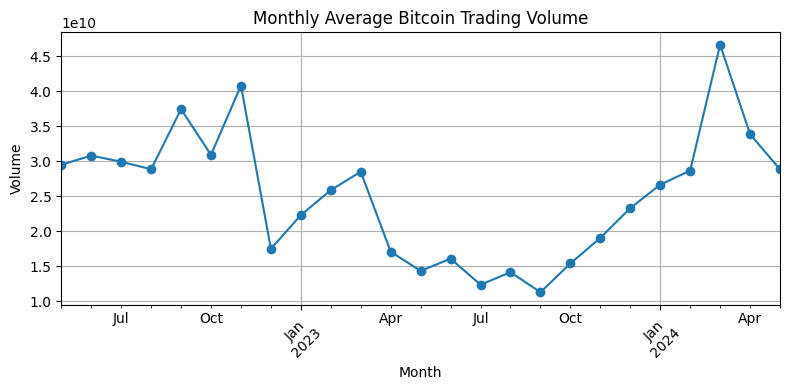

In [149]:
bitcoin_df = pd.DataFrame(df)

# Calculate monthly average Bitcoin trading volume
bitcoin_df['Month'] = bitcoin_df['Date'].dt.to_period('M')  # Extract month from date
monthly_avg_volume = bitcoin_df.groupby('Month')['Volume'].mean()

# Plot the monthly average Bitcoin trading volume
plt.figure(figsize=(8, 4))
monthly_avg_volume.plot(marker='o', linestyle='-')
plt.title('Monthly Average Bitcoin Trading Volume')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **2. Feature Engineering (FE)**

In [150]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2557,2022-05-21,29199.859375,29588.869141,29027.394531,29432.226563,29432.226563,17274840442
2558,2022-05-22,29432.472656,30425.861328,29275.183594,30323.722656,30323.722656,21631532270
2559,2022-05-23,30309.396484,30590.585938,28975.560547,29098.910156,29098.910156,31483454557
2560,2022-05-24,29101.125000,29774.355469,28786.589844,29655.585938,29655.585938,26616506245
2561,2022-05-25,29653.134766,30157.785156,29384.949219,29562.361328,29562.361328,27525063551


In [151]:
# Save dataset for future use
df_copy = df.copy()

#### **2.1 Adding Day_of_Week , Month Columns**

In [152]:
# Assuming your DataFrame is named 'df'
# Adding 'Day of Week' indicator column (0=Monday, 6=Sunday)
df['Day_of_Week'] = df['Date'].dt.dayofweek

# Adding 'Month' indicator column (1=January, 12=December)
df['Month'] = df['Date'].dt.month

#### **2.2 Adding Indicators Values to Model**

In [153]:
# Adding 7-day exponential moving average (EMA) for 'Price'
df['7_day_EMA'] = df['Close'].ewm(span=7, adjust=False).mean()

# Calculating Ichimoku Cloud lines
# Conversion Line (Tenkan-sen): (9-period high + 9-period low) / 2
df['9_high'] = df['High'].rolling(window=9).max()
df['9_low'] = df['Low'].rolling(window=9).min()
df['Tenkan_sen'] = (df['9_high'] + df['9_low']) / 2

# Base Line (Kijun-sen): (26-period high + 26-period low) / 2
df['26_high'] = df['High'].rolling(window=26).max()
df['26_low'] = df['Low'].rolling(window=26).min()
df['Kijun_sen'] = (df['26_high'] + df['26_low']) / 2

# Leading Span A (Senkou Span A): (Conversion Line + Base Line) / 2 shifted 26 periods ahead
df['Senkou_Span_A'] = ((df['Tenkan_sen'] + df['Kijun_sen']) / 2).shift(26)

# Leading Span B (Senkou Span B): (52-period high + 52-period low) / 2 shifted 26 periods ahead
df['52_high'] = df['High'].rolling(window=52).max()
df['52_low'] = df['Low'].rolling(window=52).min()
df['Senkou_Span_B'] = ((df['52_high'] + df['52_low']) / 2).shift(26)

# Lagging Span (Chikou Span): 'Price' shifted 26 periods back
df['Chikou_Span'] = df['Close'].shift(-26)

# Dropping intermediate calculation columns
df.drop(columns=['9_high', '9_low', '26_high', '26_low', '52_high', '52_low', 'Adj Close'], inplace=True)

df.dropna(inplace =True)

# Display the first few rows of the updated DataFrame
df.head()

,Date,Open,High,Low,Close,Volume,Day_of_Week,Month,7_day_EMA,Tenkan_sen,Kijun_sen,Senkou_Span_A,Senkou_Span_B,Chikou_Span
2634,2022-08-06,23291.423828,23326.562500,22961.279297,22961.279297,15978259885,5,8,23021.624059,23529.140625,21786.266601,20464.859375,24979.243164,20127.140625
2635,2022-08-07,22963.505859,23359.009766,22894.556641,23175.890625,15886817043,6,8,23060.190701,23529.140625,21786.266601,20350.393066,24979.243164,19969.771484
2636,2022-08-08,23179.527344,24203.689453,23176.546875,23809.486328,28575544847,0,8,23247.514607,23344.695312,22130.918946,20334.614746,24979.243164,19832.087891
2637,2022-08-09,23811.484375,23898.615234,22982.000000,23164.318359,23555719219,1,8,23226.715545,23344.695312,22484.790039,20424.247070,24979.243164,19986.712891
2638,2022-08-10,23162.898438,24127.414063,22771.519531,23947.642578,32837431722,2,8,23406.947304,23344.695312,22545.739258,20589.873047,24979.243164,19812.371094


#### **2.3 Adding Returns**

In [154]:
# Calculate daily returns
df['Returns'] = df['Close'].pct_change() * 100

In [155]:
df = df.dropna()

#### **2.4 Set 'Date' Index**

In [156]:
#Set 'Date' as index
df.set_index('Date', inplace=True)

#### **2.5 Add Lag Features**

In [157]:
# Add lag variables for all columns
for col in df.columns:
    for lag in range(1, 8):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Remove any null values
df.dropna(inplace=True)

df.head()

,Open,High,Low,Close,Volume,Day_of_Week,Month,7_day_EMA,Tenkan_sen,Kijun_sen,...,Chikou_Span_lag5,Chikou_Span_lag6,Chikou_Span_lag7,Returns_lag1,Returns_lag2,Returns_lag3,Returns_lag4,Returns_lag5,Returns_lag6,Returns_lag7
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-14,24429.056641,24974.914063,24206.259766,24319.333984,22994133555,6,8,24023.867733,23873.216797,22875.865235,...,19986.712891,19832.087891,19969.771484,0.087080,1.858660,0.041285,3.381598,-2.709710,2.733857,0.934666
2022-08-15,24318.316406,25135.589844,23839.775391,24136.972656,35123501685,0,8,24052.143964,23953.554688,22956.203125,...,19812.371094,19986.712891,19832.087891,-0.428816,0.087080,1.858660,0.041285,3.381598,-2.709710,2.733857
2022-08-16,24126.136719,24228.416016,23733.500000,23883.291016,27753685646,1,8,24009.930727,23953.554688,22956.203125,...,18837.667969,19812.371094,19986.712891,-0.749862,-0.428816,0.087080,1.858660,0.041285,3.381598,-2.709710
2022-08-17,23881.316406,24407.058594,23243.353516,23335.998047,30931623076,2,8,23841.447557,23953.554688,22956.203125,...,19290.324219,18837.667969,19812.371094,-1.051009,-0.749862,-0.428816,0.087080,1.858660,0.041285,3.381598
2022-08-18,23341.039063,23563.832031,23177.601563,23212.738281,23747613147,3,8,23684.270238,23953.554688,22956.203125,...,19329.833984,19290.324219,18837.667969,-2.291531,-1.051009,-0.749862,-0.428816,0.087080,1.858660,0.041285


#### **2.7 Save Transformed Data**

In [159]:
#Save a copy
df_trans = df.copy()

In [160]:
start_date = df_trans.index[0]
end_date = df_trans.index[-1]

print(f"Date range: {start_date} to {end_date}")

Date range: 2022-08-14 00:00:00 to 2024-04-25 00:00:00


In [161]:
df_trans.shape

(621, 112)

#### **2.8 Filter Dataset for 1 Year**

In [164]:
start_date = '2023-04-26'
df = df.loc[start_date:]

In [165]:
df.shape

(366, 112)

#### **2.9 Train Test Split**

In [166]:
test_size = 0.2  # 20% of the data will be used for testing

# Calculate the index to split the data
split_index = int(len(df) * (1 - test_size))

# Split the data into train and test sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Print the shapes of the resulting DataFrames
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (292, 112)
Testing set shape: (74, 112)


# **3. Model Building**

#### **3.2 X,Y Split**

In [167]:
# X,Y Split
X_train = train_df.drop(['Close'], axis=1).values
test_df_features = test_df.drop([ 'Close'], axis=1).values

y_train = train_df['Close'].values
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))


#### **3.2 Standardizing Data**

In [168]:
# Scale down X_train and y_train separately
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
test_df_features_scaled = X_scaler.transform(test_df_features.reshape(-1, test_df_features.shape[1])).reshape(test_df_features.shape)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

#### **3.3 Define Model Evaluation Function**

In [169]:
# Define functions to evaluate and simulate trading strategy
def evaluate_model(actual_prices, predictions):
    mse = mean_squared_error(actual_prices, predictions)
    mae = mean_absolute_error(actual_prices, predictions)

    returns = (predictions[1:] - predictions[:-1]) / predictions[:-1]
    sharpe_ratio = returns.mean() / returns.std()
    total_return = (predictions[-1] - predictions[0]) / predictions[0]
    std_returns = returns.std()

    return mse, mae, sharpe_ratio, total_return, std_returns


#### **3.4 Define Simulation Strategy Function**

In [170]:
def simulate_trading_strategy(actual_prices, predictions):
    initial_balance = 10000
    balance = initial_balance
    position = 0

    for i in range(1, len(predictions)):
        if predictions[i] > actual_prices[i-1]:
            if position == 0:
                position = balance / actual_prices[i-1]
                balance = 0
        elif predictions[i] < actual_prices[i-1]:
            if position > 0:
                balance = position * actual_prices[i-1]
                position = 0

    if position > 0:
        balance = position * actual_prices[-1]

    return (balance - initial_balance) / initial_balance

#### **3.5 Define Results Array**

In [171]:
# Store results
results = {
    "Model": [],
    "MSE": [],
    "MAE": [],
    "Sharpe Ratio": [],
    "Total Return": [],
    "Std of Returns": [],
    "Trading Return": []
}

#### **3.6 Model Building**

## **Model 01 - LSTM with Simple Architecture**

#### **Model 01 - Training**

In [173]:
# Build the LSTM model without regularization
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(500, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(250))
model.add(Dense(50))
model.add(Dense(8))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=8,
                    epochs=200,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - loss: 0.0443 - val_loss: 0.0068
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0027 - val_loss: 0.0132
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0018 - val_loss: 0.0096
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 9.9732e-04 - val_loss: 0.0027
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 7.7641e-04 - val_loss: 0.0035
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 5.2070e-04 - val_loss: 0.0032
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 8.9848e-04 - val_loss: 0.0019
Epoch 12/200
30/30 ━━━━━━━━

#### **Model 01 - Train vs Validation Loss**

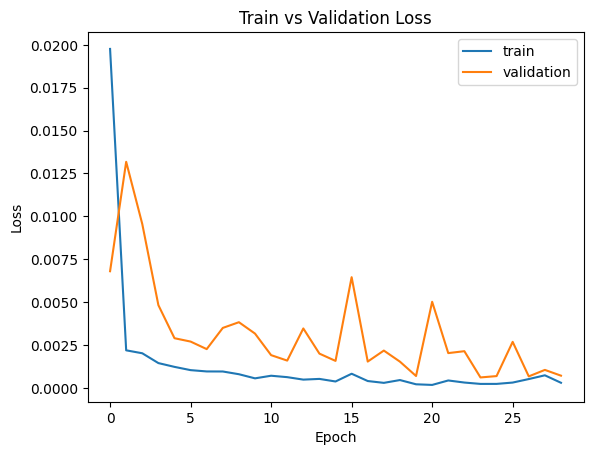

In [175]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### **Model 01 - Test Model**

In [177]:
# Reshape the scaled features to match the LSTM input shape
test_df_features_scaled_reshaped = test_df_features_scaled.reshape(-1, 1, test_df_features_scaled.shape[1])

# Make predictions on the reshaped test data
predictions_scaled = model.predict(test_df_features_scaled_reshaped)

# Inverse transform the predictions
predictions = y_scaler.inverse_transform(predictions_scaled).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


#### **Model 01 - Actual vs Predicted Prices**

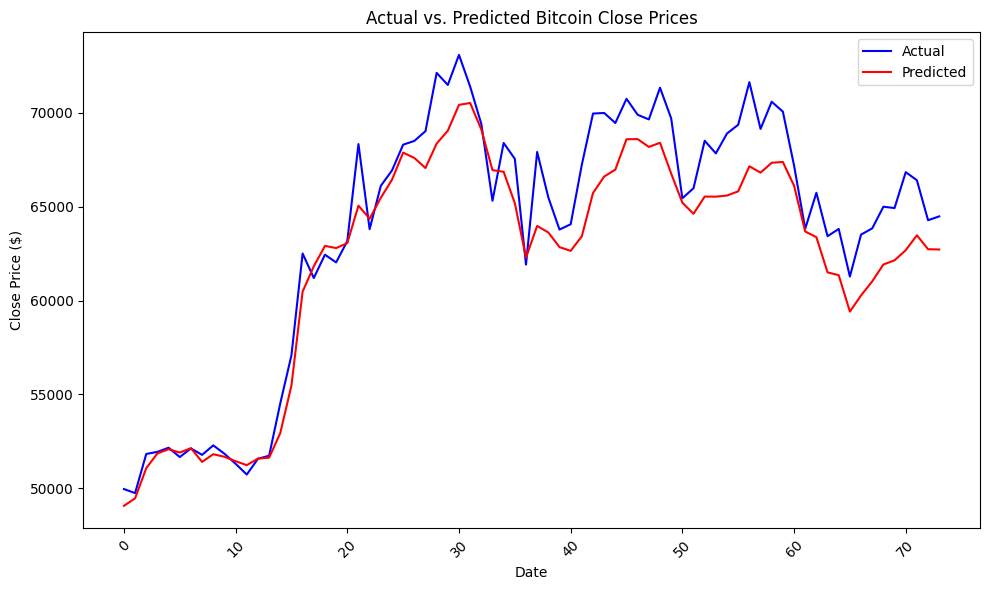

In [180]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['Close'], label='Actual', color='blue')
plt.plot(test_df.index, predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Bitcoin Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Model 01 - Actual vs Predicted Prices**

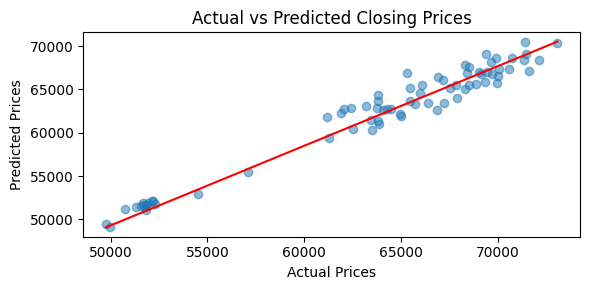

In [181]:
# Plot actual vs predicted
plt.figure(figsize=(6, 3))
plt.scatter(test_df['Close'], predictions, alpha=0.5)
plt.plot([min(test_df['Close']), max(test_df['Close'])], [min(predictions), max(predictions)], color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.tight_layout()
plt.show()

#### **Model 01 - Predicted 5 Days**

In [194]:
# Get the last window of data from the test set
last_window = test_df_features_scaled[-1]

# Initialize a list to store the predictions
forecast = []

# Make predictions for the next 5 days
for _ in range(5):
    # Reshape the last window to match the LSTM input shape
    last_window_reshaped = last_window.reshape(1, 1, last_window.shape[0])
    
    # Make a prediction for the next day
    next_day_prediction_scaled = model.predict(last_window_reshaped)
    
    # Inverse transform the prediction to get back to the original scale
    next_day_prediction = y_scaler.inverse_transform(next_day_prediction_scaled).flatten()[0]
    
    # Append the prediction to the forecast list
    forecast.append(next_day_prediction)
    
    # Update the last window with the new prediction for the next iteration
    last_window = np.append(last_window[1:], next_day_prediction_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [195]:
# Print future predictions
print("Future Predictions:")
for i, prediction in enumerate(forecast):
    print(f"Day {i+1}: Predicted Close Price = {prediction:.2f}")

Future Predictions:
Day 1: Predicted Close Price = 62718.29
Day 2: Predicted Close Price = 67388.85
Day 3: Predicted Close Price = 65441.36
Day 4: Predicted Close Price = 61822.49
Day 5: Predicted Close Price = 61982.48


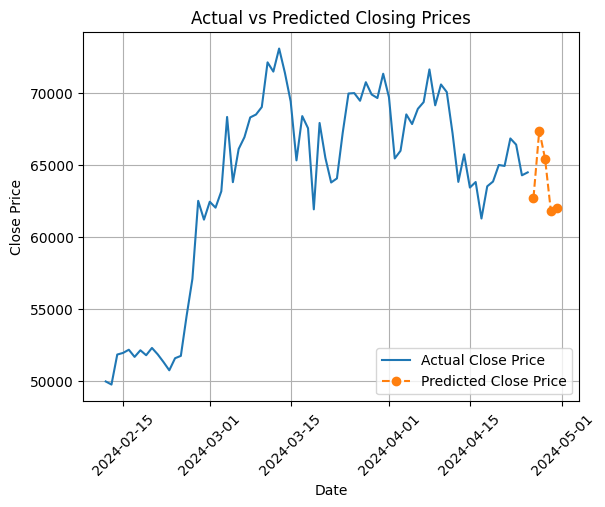

In [198]:
# Ensure 'Date' is in datetime format and set as index
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.set_index('Date', inplace=True)

# Generate future dates
future_dates = pd.date_range(start=test_df.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')

# Create a DataFrame for the future predictions
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted Close': forecast_prices})

# Plot actual closing prices
plt.plot(test_df.index, test_df['Close'], label='Actual Close Price')

# Plot future predictions
plt.plot(forecast_df['Date'], forecast_df['Predicted Close'], label='Predicted Close Price', linestyle='--', marker='o')

plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### **Model 01 - Evaluate Results**

In [196]:
# Evaluate LSTM model 1
lstm_mse, lstm_mae, lstm_sharpe_ratio, lstm_total_return, lstm_std_returns = evaluate_model(test_df['Close'], predictions)
lstm_trading_return = simulate_trading_strategy(test_df['Close'].values, predictions).flatten()

results["Model"].append("LSTM Model 1")
results["MSE"].append(lstm_mse)
results["MAE"].append(lstm_mae)
results["Sharpe Ratio"].append(lstm_sharpe_ratio)
results["Total Return"].append(lstm_total_return)
results["Std of Returns"].append(lstm_std_returns)
results["Trading Return"].append(lstm_trading_return)

## **Model 2 - LSTM with Bidirectional Layers**

With a learning rate and increased patience

#### **Model 02 - Model Training**

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Bidirectional(LSTM(5000, return_sequences=True)))
model.add(Bidirectional(LSTM(500, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(250, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Define learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with learning rate schedule
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=8,
                    epochs=200,
                    validation_split=0.2,
                    callbacks=[early_stopping])


#### **Model 02 - Training vs Validation Loss**

In [ ]:
# Display training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### **Model 02 - Test Model**

In [ ]:
# Reshape the scaled features to match the LSTM input shape
test_df_features_scaled_reshaped = test_df_features_scaled.reshape(-1, 1, test_df_features_scaled.shape[1])

# Make predictions on the reshaped test data
predictions_scaled = model.predict(test_df_features_scaled_reshaped)

# Inverse transform the predictions
predictions = y_scaler.inverse_transform(predictions_scaled).flatten()

#### **Model 02 - Actual vs Predicted**

In [ ]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['Close'], label='Actual', color='blue')
plt.plot(test_df.index, predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Bitcoin Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Model 02 - Actual vs Predicted**

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(6, 3))
plt.scatter(test_df['Close'], predictions, alpha=0.5)
plt.plot([min(test_df['Close']), max(test_df['Close'])], [min(predictions), max(predictions)], color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.tight_layout()
plt.show()

#### **Model 02 - Evaluate Results**

In [ ]:
# Evaluate LSTM model 2
lstm_mse, lstm_mae, lstm_sharpe_ratio, lstm_total_return, lstm_std_returns = evaluate_model(test_df['Close'], predictions)
lstm_trading_return = simulate_trading_strategy(test_df['Close'].values, predictions).flatten()

results["Model"].append("LSTM Model 2")
results["MSE"].append(lstm_mse)
results["MAE"].append(lstm_mae)
results["Sharpe Ratio"].append(lstm_sharpe_ratio)
results["Total Return"].append(lstm_total_return)
results["Std of Returns"].append(lstm_std_returns)
results["Trading Return"].append(lstm_trading_return)

## **Model 3 - LSTM with Batch Normalization and L2 Regularization**

#### **Model 03 - Train Model**

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Bidirectional(LSTM(5000, return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(500, return_sequences=False)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(250, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(1))

# Define learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with learning rate schedule
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=8,
                    epochs=200,
                    validation_split=0.2,
                    callbacks=[early_stopping])


#### **Model 03 - Training vs Validation Loss**

In [ ]:
# Display training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### **Model 03 - Test Model**

In [ ]:
# Reshape the scaled features to match the LSTM input shape
test_df_features_scaled_reshaped = test_df_features_scaled.reshape(-1, 1, test_df_features_scaled.shape[1])

# Make predictions on the reshaped test data
predictions_scaled = model.predict(test_df_features_scaled_reshaped)

# Inverse transform the predictions
predictions = y_scaler.inverse_transform(predictions_scaled).flatten()

#### **Model 02 - Actual vs Predicted**

In [ ]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df['Close'], label='Actual', color='blue')
plt.plot(test_df.index, predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Bitcoin Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Model 02 - Actual vs Predicted**

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(6, 3))
plt.scatter(test_df['Close'], predictions, alpha=0.5)
plt.plot([min(test_df['Close']), max(test_df['Close'])], [min(predictions), max(predictions)], color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.tight_layout()
plt.show()

#### **Model 03 - Evaluate Model**

In [ ]:
# Evaluate LSTM model 3
lstm_mse, lstm_mae, lstm_sharpe_ratio, lstm_total_return, lstm_std_returns = evaluate_model(test_df['Close'], predictions)
lstm_trading_return = simulate_trading_strategy(test_df['Close'], predictions)

# Store results in a dictionary
results = {
    "Model": ["LSTM Model 3"],
    "MSE": [lstm_mse],
    "MAE": [lstm_mae],
    "Sharpe Ratio": [lstm_sharpe_ratio],
    "Total Return": [lstm_total_return],
    "Std of Returns": [lstm_std_returns],
    "Trading Return": [lstm_trading_return]
}


#  **4. Model Selection**

In [1]:
# Convert dictionary to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Select best model based on Sharpe Ratio and Trading Return
best_model_idx = results_df[['Sharpe Ratio', 'Trading Return']].idxmax().mean().astype(int)
best_model_name = results_df.iloc[best_model_idx]['Model']

print(f"Selected Best Model: {best_model_name}")

NameError: name 'pd' is not defined

In [ ]:
# Print results
for key, value in results.items():
    print(f"{key}: {value}")